In [1]:
import numpy as np
import netCDF4 as nc # used for reading netCDF4 data
import pandas as pd
import geopandas as gpd

#from sklearn.model_selection import train_test_split
#from sklearn import neighbors
#from sklearn.metrics import mean_squared_error 
from math import sqrt
import sys
import os
import datetime as dtm # Used for comparing dates with each other
import moviepy.video.io.ImageSequenceClip    # Used for creating .gif of the data
import pickle  # for saving intermediate datasets
import logging
import xarray as xr

from sklearn.metrics import mean_squared_error # for calculating the RMSE

from statsmodels.stats.weightstats import DescrStatsW # for calculating the weighted mean and variance



from glob import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

from shapely.geometry import Point, MultiPoint
from shapely.geometry.polygon import Polygon


#sns.set(style="whitegrid", palette="pastel", color_codes=True)
sns.set(style="whitegrid", palette="colorblind", color_codes=True)
pal = sns.color_palette('colorblind')
sns.mpl.rc("figure", figsize=(10,6))

MAIN_DIR = '/projects/0/ctdas/awoude/Ritten/transport_results/'
SAVE_DIR = '/gpfs/home5/awoude/Ritten/EKF/Results/'
# continents_file = '/gpfs/home5/awoude/Ritten/EKF/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp'
continents_file = '/gpfs/home5/awoude/Ritten/EKF/Transcom_regions/transcom_regions.shp'
# '/projects/0/ctdas/ingrid/gcp2021_era5_sib4_insitu_newff_merged_output_fwd_corrected/'

pers_dat_dir = '/projects/0/ctdas/awoude/Ritten/' # For data specifically stored for my perfonal usage
pers_file_dir = '/gpfs/work1/0/ctdas/awoude/Ritten/' # For storing and retrieving my own data files
pred_var_path = '/gpfs/work1/0/ctdas/awoude/Ritten/predictor_vars/' # For retrieving the set of aggregated scaling vectors

state_vec_file = '/projects/0/ctdas/input/ctdas_2012/covariances/gridded_NH/griddedNHparameters.nc' # Used for mapping statevector to ecoregions


sf_files = sorted(glob(pers_dat_dir + 'flux_data/flux1x1_20??????00_20??????00.nc'))


# Code for generating figures Part I
This notebook contains the code for creating all the figures used in Part I, along with some minor data processing. Note that the figures are not presented in the order in which they appear in the thesis. This is a result of various revisions being made to the writen thesis in whic the order of explanation has been changed.

## 1.3
Showing reoccurring pattern in state vector

In [2]:
with xr.open_dataset(sf_files[0]) as ds:
    ds = ds
    print(ds)

<xarray.Dataset>
Dimensions:                (lon: 360, lat: 180)
Coordinates:
  * lon                    (lon) float32 -179.5 -178.5 -177.5 ... 178.5 179.5
  * lat                    (lat) float32 -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
Data variables:
    flux_multiplier_m      (lat, lon) float32 ...
    flux_all_prior_mean    (lat, lon) float32 ...
    flux_ff_prior_mean     (lat, lon) float32 ...
    flux_bio_prior_mean    (lat, lon) float32 ...
    flux_fires_prior_mean  (lat, lon) float32 ...
    flux_ocean_prior_mean  (lat, lon) float32 ...
Attributes:
    model_start_date:  2000/01/01 00:00:00 UTC
    model_end_date:    2000/01/08 00:00:00 UTC


In [3]:
regionsfile = '/gpfs/home5/awoude/Ritten/EKF/regions.nc'
with nc.Dataset(regionsfile) as ds:
    tc_names = [b''.join(n).decode().strip() for n in ds['transcom_names'][:]]
    transcom_regions = ds['transcom_regions'][:]
    tc_region_inds = sorted(np.unique(transcom_regions))
    tc_dict = {}
    for r, name in zip(tc_region_inds, tc_names):
        mask = np.where(transcom_regions==r, 1, 0)
        tc_dict[name] = mask
    all_regions = ds['regions'][:]
    unique_regions = np.unique(all_regions)
    print(unique_regions)
    all_region_matrix = np.zeros((round(np.max(unique_regions)), 180, 360))
    for r in unique_regions:
        mask = np.where(all_regions==r, 1, 0)
        all_region_matrix[round(r)-1] = mask
    all_regiondict = {}
    for r in unique_regions:
        mask = np.where(all_regions==r, 1, 0)
        all_regiondict[r] = mask
   

[  1.   3.   4.   7.   8.   9.  10.  11.  15.  16.  19.  20.  21.  22.
  23.  24.  25.  26.  27.  29.  30.  31.  32.  33.  34.  35.  38.  39.
  40.  41.  42.  43.  45.  46.  48.  49.  50.  51.  52.  57.  59.  60.
  61.  62.  63.  64.  65.  67.  68.  69.  70.  71.  73.  76.  78.  79.
  80.  81.  82.  83.  84.  86.  87.  88.  89.  90.  93.  95.  97.  98.
  99. 100. 101. 102. 103. 105. 106. 107. 108. 109. 112. 114. 115. 116.
 117. 118. 121. 122. 123. 124. 125. 128. 130. 133. 134. 135. 136. 137.
 138. 139. 140. 141. 143. 144. 145. 146. 147. 152. 154. 155. 156. 157.
 160. 162. 163. 166. 171. 172. 173. 174. 175. 176. 177. 178. 179. 181.
 183. 185. 187. 190. 191. 192. 193. 194. 195. 196. 197. 198. 199. 200.
 201. 202. 204. 206. 209. 210. 211. 212. 213. 214. 215. 216. 217. 218.
 219. 220. 221. 222. 223. 224. 225. 226. 227. 228. 229. 230. 231. 232.
 233. 234. 235. 236. 237. 238. 239. 240.]


/scratch-local/awoude/ipykernel_1231115/956939094.py:3: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  tc_names = [b''.join(n).decode().strip() for n in ds['transcom_names'][:]]


In [4]:
ecoregions_per_transcomregion = {}
with nc.Dataset(regionsfile) as ds:
    print("Printing the parameters associated with each transcom region")
    for name in tc_names:
        masked_region = tc_dict[name] * ds['regions'][:]
        ecoregions_per_transcomregion[name] = np.unique(masked_region)[1:]
        print(f'Tc region {name} contains "PFTs" {ecoregions_per_transcomregion[name]}')

Printing the parameters associated with each transcom region
Tc region North American Boreal contains "PFTs" [ 1.  3.  4.  7.  8.  9. 10. 11. 15. 16. 19.]
Tc region North American Temperate contains "PFTs" [20. 21. 22. 23. 24. 25. 26. 27. 29. 30. 31. 32. 33. 34. 35. 38.]
Tc region South American Tropical contains "PFTs" [39. 40. 41. 42. 43. 45. 46. 48. 49. 50. 51. 52. 57.]
Tc region South American Temperate contains "PFTs" [59. 60. 61. 62. 63. 64. 65. 67. 68. 69. 70. 71. 73. 76.]
Tc region Northern Africa contains "PFTs" [78. 79. 80. 81. 82. 83. 84. 86. 87. 88. 89. 90. 93. 95.]
Tc region Southern Africa contains "PFTs" [ 97.  98.  99. 100. 101. 102. 103. 105. 106. 107. 108. 109. 112. 114.]
Tc region Eurasia Boreal contains "PFTs" [115. 116. 117. 118. 121. 122. 123. 124. 125. 128. 130. 133.]
Tc region Eurasia Temperate contains "PFTs" [134. 135. 136. 137. 138. 139. 140. 141. 143. 144. 145. 146. 147. 152.]
Tc region Tropical Asia contains "PFTs" [154. 155. 156. 157. 160. 162. 163. 166. 1

In [4]:
def extract_date(f):
    date_hours = f.split('_')[-2] # extracting the first day of the week
    date = date_hours[:-2] # removing the final two number prepresenting the hours (?)
    return pd.to_datetime(date) # parse the date into the correct data type

def get_scaling_factor_all(f):
    """Calculate the scaling factor for a file for every TC region"""
    s = pd.Series(dtype='float64')
    with nc.Dataset(f) as ds:
        sf_total = ds['flux_multiplier_m']
        #print(np.shape(sf_total))
        for name, mask in all_regiondict.items():
            #print(np.sum(mask[70]))
            #print(f"eco region {name} has unique scaling factors {np.unique((sf_total * mask))}")
            masked_df = np.where(mask, sf_total, np.nan)
            if np.all(np.isnan(masked_df)):
                sf_region = np.nan
                print(f'region {name} is empty')
            else:
                sf_region = np.nanmean(np.where(mask, sf_total, np.nan))
            
            #print(mask[0])
            #print(sf_region)
            s[str(name)] = sf_region
    return s

def translate_to_PFT(ecoregion):
    ecoregion = int(float(ecoregion))
    PFT_order = {
        1: 'Conifer Forest',
        2: 'Broadleaf Forest',
        3: 'Mixed Forest',
        4: 'Grass/Shrub',
        5: 'Tropical Forest',
        6: 'Scrub/Woods',
        7: 'Semitundra',
        8: 'Fields/Woods/Savanna',
        9: 'Northern Taiga',
        10: 'Forest/Field',
        11: 'Wetland',
        12: 'Deserts',
        13: 'Shrub/Tree/Suc',
        14: 'Crops',
        15: 'Conifer Snowy/Coastal',
        16: 'Wooded tundra',
        17: 'Mangrove',
        18: 'Ice and Polar desert',
        19: 'Water'
    }
    for tcr, ecoregions in ecoregions_per_transcomregion.items():
        if ecoregion in ecoregions:
            transCom = tcr
    if ecoregion > 11*19:
        return transCom
    else:
        PFT = PFT_order[(ecoregion-1)%19+1]
        return transCom + ' - ' + PFT


In [6]:
[translate_to_PFT(x) for x in [24, 25, 30, 138, 139, 144, 192, 193, 201, 209]]

['North American Temperate - Tropical Forest',
 'North American Temperate - Scrub/Woods',
 'North American Temperate - Wetland',
 'Eurasia Temperate - Tropical Forest',
 'Eurasia Temperate - Scrub/Woods',
 'Eurasia Temperate - Wetland',
 'Europe - Broadleaf Forest',
 'Europe - Mixed Forest',
 'Europe - Wetland',
 'Europe - Water']

In [7]:
# Combine all scaling factors together in a dataframe
file_name = 'avg_flux_per_ecoregion_PFT.pkl'
file_path = pers_dat_dir + file_name
if os.path.exists(file_path):
    df = pd.read_pickle(file_path)
else: 
    df = pd.DataFrame()
    for i, f in enumerate(sf_files):
        print(f"Currently processing file #{i}")
        date = extract_date(f)
        s = get_scaling_factor_all(f)
        df[date] = s

    df = df.T
    # De-fragment:
    df = df.copy()
    # Select only land ecoregions
    # df = df[df.columns[:11]]
    df.to_pickle(filepath)
    
sf_per_ecoregion = df.copy()

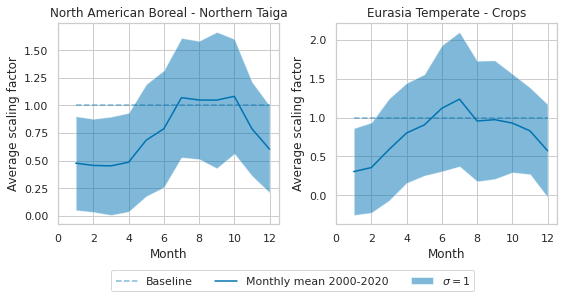

In [7]:
df = sf_per_ecoregion

grouped = df.groupby(df.index.month)

selected_ecoregions = ['9.0', '147.0'] # Select max 2

mean_1, mean_2 = [grouped.mean()[i] for i in selected_ecoregions]

error_1, error_2 = [grouped.std()[i] for i in selected_ecoregions]

count_1, count_2 = [grouped.count()[i] for i in selected_ecoregions]

base = pd.DataFrame(np.ones(shape=(12,1)), index=range(1, 13)) # used for drawing line at sf=1

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))
# fig.suptitle('Mean scaling factor over aggregated grid cells.', fontsize=20)
ax1.set_title(translate_to_PFT(selected_ecoregions[0]))

    
ax1.plot(base, color='b', alpha=0.5, linestyle='dashed', label='Baseline')
ax1.plot(mean_1, label='Monthly mean 2000-2020')
ax1.fill_between(np.unique(df.index.month), mean_1-error_1, mean_1+error_1, 
                 alpha=0.5, label=''r'$\sigma=1$')
ax1.set(xlabel='Month', ylabel='Average scaling factor', xticks=range(0,13,2))
ax1.label_outer()

ax2.set_title(translate_to_PFT(selected_ecoregions[1]))
ax2.plot(base, color='b', alpha=0.5, linestyle='dashed', label='Baseline')
ax2.plot(mean_2, label='Monthly mean 2000-2020')
ax2.fill_between(np.unique(df.index.month), mean_2-error_2, mean_2+error_2, 
                 alpha=0.5, label=r'$\sigma=1$')
ax2.set(xlabel='Month', ylabel='Average scaling factor', xticks=range(0,13,2))
# ax2.label_outer()
# ax2.label_outer()
fig.tight_layout()
plt.legend(bbox_to_anchor =(0.65, -0.2), ncol=3)

plt.gcf().subplots_adjust(bottom=0.20)

# Results part I

## creating statevector dataset

In [8]:
# File is created in ML-implementations.ipynb
file = '/gpfs/work1/0/ctdas/awoude/Ritten/weekly_sv.nc'
with xr.open_dataset(file) as ds:
    weekly_sv = ds.flux_multiplier_m.to_pandas()

# File created in Data_visualisation.ipynb

file = '/projects/0/ctdas/awoude/Ritten/smoothed_sv.pkl'

with open(file, 'rb') as handle:
    smoothed_sv = pickle.load(handle)


In [9]:
df = weekly_sv

train_set = df[df.index.year <= 2018]
test_set_2019 = df[df.index.year == 2019]
test_set_2020 = df[df.index.year == 2020]
test_set_19_20 = df[df.index.year >= 2019]

grouped_train = train_set.groupby(train_set.index.month).mean()
grouped_2019 = test_set_2019.groupby(test_set_2019.index.month).mean()
grouped_2020 = test_set_2020.groupby(test_set_2020.index.month).mean()

base = pd.DataFrame(np.ones(shape=np.shape(grouped_train)), columns=df.columns, index=grouped_train.index)


In [9]:
len(train_set)

992

## creating flux landscape

In [10]:
path = '/projects/0/ctdas/awoude/Ritten/'
files = sorted(glob(path + 'flux_data/flux1x1_20??????00_20??????00.nc'))

def extract_date(f):
    date_hours = f.split('_')[-2] # extracting the first day of the week
    date = date_hours[:-2] # removing the final two number prepresenting the hours (?)
    return pd.to_datetime(date) # parse the date into the correct data type

def calc_area(lats, lons):
    ''' Calculates the surface area [m2]of a grid spanned by lon and lat.
    Assumes lon,lat are evenly spaced (in degrees) vectors.
    Assumes lon,lat indicate center points
    Assumes the globe is a perfect sphere.
    Written by M Molen'''
    R            = 6370e3 # [m] the radius of the earth and h is the perpendicular distance from the plane containing the line of latitude to the pole.
    # grid spacing (degrees)
    dlon         = np.gradient(lons).mean()
    dlat         = np.gradient(lats).mean()
    # initialize A (surface area of grid point)
    nlon         = len(lons)
    nlat         = len(lats)
    A            = np.zeros((nlat, nlon))
    for iy in range(nlat):
        Alat     = 2*np.pi*np.square(R) * np.abs( np.sin(2*np.pi*(lats[iy]-dlat/2.)/360.) -np.sin(2*np.pi*(lats[iy]+dlat/2.)/360.)) * np.abs(dlon)/360. # m2
        A[iy, :] = Alat
    return A # m2

In [11]:
opt_ocean_bio = {}
for i, f in enumerate(files):
    if i%100==0:
        print(f"Currently processing file #{i}")
    with nc.Dataset(f) as ds:
        date = extract_date(f)
        combined_ocean_bio = np.add(ds['flux_bio_prior_mean'][:], ds['flux_ocean_prior_mean'][:])
        opt_ocean_bio[date] = combined_ocean_bio * ds['flux_multiplier_m']

Currently processing file #0
Currently processing file #100
Currently processing file #200
Currently processing file #300
Currently processing file #400
Currently processing file #500
Currently processing file #600
Currently processing file #700
Currently processing file #800
Currently processing file #900
Currently processing file #1000


In [12]:
prior_fluxes = {}
for i, f in enumerate(files):
    if i%100==0:
        print(f"Currently processing file #{i}")
    date = extract_date(f)
    with nc.Dataset(f) as ds:
        comb = np.add(ds['flux_bio_prior_mean'][:], ds['flux_ocean_prior_mean'][:])
    prior_fluxes[date] = comb

print(prior_fluxes)

Currently processing file #0
Currently processing file #100
Currently processing file #200
Currently processing file #300
Currently processing file #400
Currently processing file #500
Currently processing file #600
Currently processing file #700
Currently processing file #800
Currently processing file #900
Currently processing file #1000
{Timestamp('2000-01-01 00:00:00'): masked_array(
  data=[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [-3.57316132e-08, -3.57316132e-08, -3.52387524e-08, ...,
         -3.45118849e-08, -3.42933149e-08, -3.42933149e-08],
        [-1.13040519e-08, -1.13040519e-08, -1.15427463e-08, ...,
         -1.03015187e-08, -1.

In [13]:
# File is created in ML-implementations.ipynb
file = '/gpfs/work1/0/ctdas/awoude/Ritten/weekly_sv.nc'
with xr.open_dataset(file) as ds:
    weekly_sv = ds.flux_multiplier_m.to_pandas()

df = weekly_sv

train_set = df[df.index.year <= 2018]

grouped_train = train_set.groupby(train_set.index.month).mean()

base = pd.DataFrame(np.ones(shape=np.shape(grouped_train)), columns=df.columns, index=grouped_train.index)


# File is created in Data_visualisation.ipynb
file_path = '/projects/0/ctdas/awoude/Ritten/smoothed_sv.pkl'

if os.path.exists(file_path):
    with open(file_path, 'rb') as handle:
        smoothed_sv = pickle.load(handle)

In [16]:
def filter_date_by_year(arr, start, end=2021):
    start_date = pd.to_datetime(str(start)+'0101')
    end_date = pd.to_datetime(str(end)+'0101')
    filtered_arr = arr[np.where((arr >= start_date) & (arr < end_date))]
    return filtered_arr

keys = np.array(weekly_sv.index)
dates_2019_2020 = filter_date_by_year(keys, 2019, 2021)

lon = np.linspace(-179.5, 179.5, 360, endpoint=True)

lat = np.linspace(-89.5, 89.5, 180, endpoint=True)
opt_data = list(opt_ocean_bio.values())
prior_data = list(prior_fluxes.values())

opt_flux = xr.DataArray(
    name='opt_flux',
    data=opt_data,
    dims=["time", "lat", "lon"],
    coords=dict(
        lon=(["lon"], lon),
        lat=(["lat"], lat),
        time=list(opt_ocean_bio.keys()),
    ),
    attrs=dict(
        description="Optimised ocean and biosphere flux",
        units="molC/s",
    ),
)

prior_flux = xr.DataArray(
    name='prior_flux',
    data=prior_data,
    dims=["time", "lat", "lon"],
    coords=dict(
        lon=(["lon"], lon),
        lat=(["lat"], lat),
        time=list(opt_ocean_bio.keys()),
    ),
    attrs=dict(
        description="Prior ocean and biosphere flux",
        units="molC/s",
    ),
)
area_per_grid_cell = calc_area(opt_flux.lat,opt_flux.lon)
area_per_grid_cell
cell_area_ds = xr.DataArray(
    name='cell_area',
    data=area_per_grid_cell,
    dims=["lat", "lon"],
    coords=dict(
        lon=(["lon"], lon),
        lat=(["lat"], lat),
    ),
    attrs=dict(
        description="Surface area of indiviual grid cells",
        units="m^2",
    ),
)

resp_file = '/home/awoude/notebooks/ForRitten/SiB4_TER_avg.nc'
with xr.open_dataset(resp_file) as ds:
    ds = ds.swap_dims({"Longitude": "lon", "Latitude":"lat"})
    ds = ds.reset_coords(names=['Longitude' ,'Latitude'], drop=True)
    
    resp_ds = ds*cell_area_ds  # moving from [umol m^2 s^1] to [umol s^1]

state_vec_file = '/projects/0/ctdas/input/ctdas_2012/covariances/gridded_NH/griddedNHparameters.nc'
with xr.open_dataset(state_vec_file) as ds:
    state_vec_params = ds
    # fixing minor error in the naming of dimensions in the source file:
    ds = ds.swap_dims({"longitude": "lon2", "latitude":"lat2", "lon":"lon2", "lat":"lat2"})
    ds = ds.swap_dims({"lon2": "lon", "lat2":"lat"})
    ds = ds.reset_coords(names=['longitude' ,'latitude'], drop=True)
    
    state_elem_ds = ds

flux_ds = xr.merge([opt_flux, prior_flux, state_elem_ds, cell_area_ds, resp_ds])

In [17]:
keys = np.array(weekly_sv.index)

print(keys)
# Selecting the relevant dates from the list of all dates
dates_2019_2020 = filter_date_by_year(keys, 2019, 2021)

# Store the sum of error^2 over each grid cell
error_prior_sv_df = pd.DataFrame(columns=dates_2019_2020, index=weekly_sv.columns)
error_monthly_sv_df = pd.DataFrame(columns=dates_2019_2020, index=weekly_sv.columns)
error_smooth_sv_df = pd.DataFrame(columns=dates_2019_2020, index=weekly_sv.columns)

error_prior_flux_df = pd.DataFrame(columns=dates_2019_2020, index=weekly_sv.columns)
error_monthly_flux_df = pd.DataFrame(columns=dates_2019_2020, index=weekly_sv.columns)
error_smooth_flux_df = pd.DataFrame(columns=dates_2019_2020, index=weekly_sv.columns)

# conversion factor [molC/s] -> [PgC/yr]
fac= 86400.*365.*12./1e15
    
#weight_region = flux_ds['regions', 'cell_area'].groupby('regions').sum()
flux_m2_ds = flux_ds[['prior_flux','opt_flux']]*flux_ds.cell_area*fac

flux_m2_ds.attrs['desciption'] = 'Fluxes muliplied with surface area to which they apply'
flux_m2_ds = xr.merge([flux_m2_ds, flux_ds.regions])
flux_per_region = flux_m2_ds.groupby('regions').sum()
# For each week, determine the sum(error^2)
for date in dates_2019_2020[:]:
    print(f'Currently processing date: {date}')

    opt_sv = weekly_sv.loc[date]
    prior_sv = np.ones(np.shape(opt_sv))
    
    
    opt_flux = flux_per_region.opt_flux.sel(time=date)
    prior_flux = flux_per_region.prior_flux.sel(time=date)
    
    month = date.astype('datetime64[M]').astype(int) % 12 + 1        
    sv_monthly = grouped_train.loc[month]
    sv_smooth = smoothed_sv.loc[date]
    
    

    flux_monthly = prior_flux*sv_monthly
    flux_smooth = prior_flux*sv_smooth
    
    error_prior_sv = np.subtract(prior_sv, opt_sv)
    error_monthly_sv = np.subtract(sv_monthly, opt_sv)
    error_smooth_sv = np.subtract(sv_smooth, opt_sv) 
    
    error_monthly_sv_df[date] = error_monthly_sv
    error_prior_sv_df[date] = error_prior_sv
    error_smooth_sv_df[date] = error_smooth_sv
    
    error_prior_flux = np.subtract(prior_flux, opt_flux)
    error_monthly_flux = np.subtract(flux_monthly, opt_flux)
    error_smooth_flux = np.subtract(flux_smooth, opt_flux) 
    
    error_monthly_flux_df[date] = error_monthly_flux
    error_prior_flux_df[date] = error_prior_flux
    error_smooth_flux_df[date] = error_smooth_flux
    
    
# error_per_ecoregion_monthly = error_per_ecoregion_monthly.copy()
# error_per_ecoregion_prior = error_per_ecoregion_prior.copy()
# error_per_ecoregion_smooth = error_per_ecoregion_smooth.copy()

error_monthly_sv_df = error_monthly_sv_df.T
error_prior_sv_df = error_prior_sv_df.T
error_smooth_sv_df = error_smooth_sv_df.T

error_monthly_flux_df = error_monthly_flux_df.T
error_prior_flux_df = error_prior_flux_df.T
error_smooth_flux_df = error_smooth_flux_df.T


['2000-01-01T00:00:00.000000000' '2000-01-08T00:00:00.000000000'
 '2000-01-15T00:00:00.000000000' ... '2020-12-12T00:00:00.000000000'
 '2020-12-19T00:00:00.000000000' '2020-12-26T00:00:00.000000000']
Currently processing date: 2019-01-05T00:00:00.000000000
Currently processing date: 2019-01-12T00:00:00.000000000
Currently processing date: 2019-01-19T00:00:00.000000000
Currently processing date: 2019-01-26T00:00:00.000000000
Currently processing date: 2019-02-02T00:00:00.000000000
Currently processing date: 2019-02-09T00:00:00.000000000
Currently processing date: 2019-02-16T00:00:00.000000000
Currently processing date: 2019-02-23T00:00:00.000000000
Currently processing date: 2019-03-02T00:00:00.000000000
Currently processing date: 2019-03-09T00:00:00.000000000
Currently processing date: 2019-03-16T00:00:00.000000000
Currently processing date: 2019-03-23T00:00:00.000000000
Currently processing date: 2019-03-30T00:00:00.000000000
Currently processing date: 2019-04-06T00:00:00.000000000
Cu

## Figure 4.5
Predicted lambda vs. analyzed lambda

<Figure size 504x216 with 0 Axes>

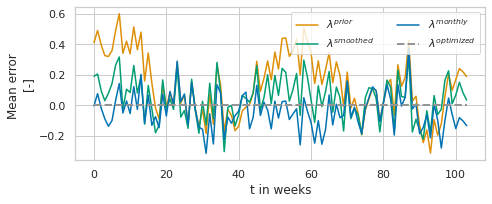

In [18]:

d1 = DescrStatsW(error_prior_sv_df.T)
d2 = DescrStatsW(error_smooth_sv_df.T)
d3 = DescrStatsW(error_monthly_sv_df.T)
plt.figure(figsize=(7,3))
fig, ax1 = plt.subplots(1,1, figsize=(7,3))

ax1.plot(d1.mean, label=r'$\lambda^{prior}$', color='C01')
ax1.plot(d2.mean, label=r'$\lambda^{smoothed}$', color='C02')
ax1.plot(d3.mean, label=r'$\lambda^{monthly}$', color='C00')
ax1.plot(np.zeros(len(d1.mean)), color='C07',linewidth=2, linestyle='dashed', label=r'$\lambda^{optimized}$')

# square_err_per_week['bias_monthly_avg'].plot(label='x=model_(monthly)')
# square_err_per_week['bias_prior'].plot(label='x=model_(prior)')
#ax1.set_title('Mean error')
ax1.set_xlabel('t in weeks')
ax1.set_ylabel('Mean error \n'r'[-]')
ax1.legend(ncol=2)
#ax1.tight_layout()
#d.std_mean
# print(error_per_ecoregion_monthly.T)
# print(list(weight_ecoregion.values()))

# ax2.plot(d1.std_mean, label=r'$\lambda^{monthly}$')
# ax2.plot(d2.std_mean, label=r'$\lambda^{prior}$')
# ax2.plot(d3.std_mean, label=r'$\lambda^{smoothed}$')

# ax2.set_title(r'$\sigma=1}$')
# ax2.set_xlabel('t in weeks')
# ax2.set_ylabel('Standard devation of error d[-]')
# ax2.legend()
plt.tight_layout()
plt.savefig('../figures/bias_sv_stddev_per_week.pdf')
plt.show()

In [19]:
print(f'mean error prior: {np.mean(d1.mean)}')
print(f'mean error smoothed: {np.mean(d2.mean)}')
print(f'mean error monthly: {np.mean(d3.mean)}')

mean error prior: 0.14140996215618987
mean error smoothed: 0.04550259136345271
mean error monthly: -0.036284144207634345


## Figure 4.3
Predicted flux landscape vs. analyzed flux landscape

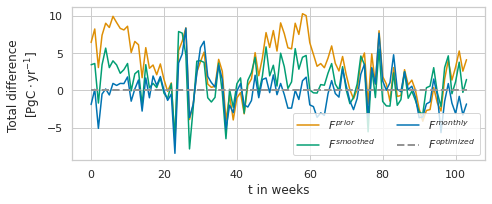

In [20]:

d1 = DescrStatsW(error_prior_flux_df.T)
d2 = DescrStatsW(error_smooth_flux_df.T)
d3 = DescrStatsW(error_monthly_flux_df.T)

fig, ax1 = plt.subplots(1,1, figsize=(7,3))

ax1.plot(d1.sum, label=r'$F^{prior}$', color='C01')
ax1.plot(d2.sum, label=r'$F^{smoothed}$', color='C02')
ax1.plot(d3.sum, label=r'$F^{monthly}$', color='C00')
ax1.plot(np.zeros(len(d1.mean)), color='C07',linewidth=2, linestyle='dashed', label=r'$F^{optimized}$')

# square_err_per_week['bias_monthly_avg'].plot(label='x=model_(monthly)')
# square_err_per_week['bias_prior'].plot(label='x=model_(prior)')
# ax1.set_title('Total error')
ax1.set_xlabel('t in weeks')
ax1.set_ylabel('Total difference \n'r'[$\mathrm{PgC\cdot yr^{-1}}$]')
ax1.legend()
#ax1.tight_layout()
#d.std_mean
# print(error_per_ecoregion_monthly.T)
# print(list(weight_ecoregion.values()))

# ax2.plot(d1.std_mean, label='monthly')
# ax2.plot(d2.std_mean, label='prior')
# ax2.plot(d3.std_mean, label='smoothed')

# ax2.set_title(r'$\sigma=1}$')
# ax2.set_xlabel('t in weeks')
# ax2.set_ylabel('Standard devation of error d[ppm]')
# ax2.legend()
plt.legend(ncol=2)
plt.tight_layout()
plt.savefig('../figures/bias_flux_per_week.pdf')
#plt.show()

In [19]:
print(f'mean error monthly: {np.mean(d1.sum)} PgC/yr')
print(f'mean error prior: {np.mean(d2.sum)} PgC/yr')
print(f'mean error smoothed: {np.mean(d3.sum)} PgC/yr')

mean error monthly: 3.1141576247862375 PgC/yr
mean error prior: 1.1420846413995471 PgC/yr
mean error smoothed: -0.07184462048514427 PgC/yr


In [21]:
resp_per_sv_elem = flux_ds[['TER', 'regions']].groupby('regions').sum()


## Figure 4.4
Distribution of TER per state vector element

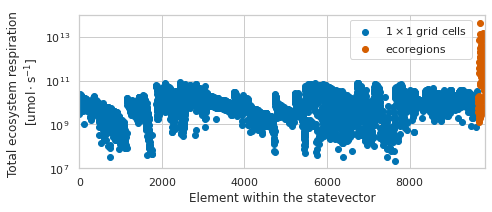

In [25]:

plt.figure(figsize=(7,3))
plt.scatter(resp_per_sv_elem.regions[:-145], resp_per_sv_elem.TER[:-145], color='C0', label=r'$1\times1$ grid cells')

plt.scatter(resp_per_sv_elem.regions[-145:], resp_per_sv_elem.TER[-145:], color='C3', label='ecoregions')
plt.legend(bbox_to_anchor =(0.98, 1))
plt.yscale('log')
plt.xlabel('Element within the state vector')
plt.ylabel('Total ecosystem respiration \n'r'[$\mathrm{umol \cdot s^{-1}}$]')
plt.xlim([0, 9835])
plt.ylim([1e7,1e14])
plt.tight_layout()
plt.savefig('../figures/TER_dist.pdf')

In [34]:
region_index_max=resp_per_sv_elem.where(resp_per_sv_elem.TER == resp_per_sv_elem.TER.max(), drop=True).regions.values[0]
resp_per_sv_elem.sel(regions=region_index_max)

<xarray.Dataset>
Dimensions:  ()
Coordinates:
    regions  float64 9.695e+03
Data variables:
    TER      float64 3.587e+03

# figure 2

In [4]:
def get_state_vec(f, state_elem_ds):
    with xr.open_dataset(f) as ds:
        sf_total  = ds['flux_multiplier_m']
        # combined dataset in which the elements of the state vector and the scaling vectors are aligned based on longitude and latitude
        comb = state_elem_ds.merge(sf_total)
        print(comb)
        gr = comb.groupby('regions').max()['flux_multiplier_m'] # All values should be the same, so taking the max or min should not make a difference
        return gr
    
def count(list1, l, r):
     
    # Traversing the list with on line for loop
    # check if number is in range of not
    return sum( l <= x <= r for x in list1)

In [5]:
file_name = 'weekly_sv.nc'
file_path = pers_file_dir + file_name
if os.path.exists(file_path):
    with xr.open_dataset(file_path) as ds:
        ds = ds.rename_vars({"flux_multiplier_m": "sf"})
        # ds = ds.to_dataset()
        weekly_sv = ds

[[-1.13899422 -0.40715319  3.08963633 ...  1.13283288  0.03825409
   1.        ]
 [ 0.72610188  1.02900028  0.8129912  ...  1.17254329 -0.25256792
   1.        ]
 [-0.53964245  0.46649936  0.12577882 ... -1.00085664  3.6250422
   1.        ]
 ...
 [ 1.66622865  1.87580526  2.07583857 ...  1.95696664 -0.00396654
   1.        ]
 [ 0.26539034 -0.04203299  0.38370159 ...  1.11540735  1.07112217
   1.        ]
 [ 2.39722824  1.52144599  1.06871021 ...  1.84845352  0.17224295
   1.        ]]


/scratch-local/awoude/ipykernel_1231115/3668066320.py:33: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x14d62a0216a0>] instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend(new_handles, new_labels)


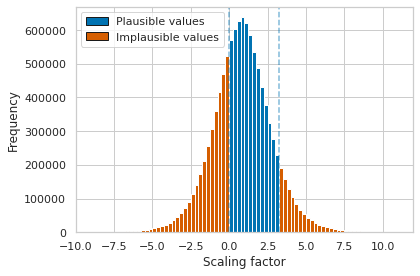

Ratio in range: 0.5657561948438755


In [6]:
from matplotlib.patches import Rectangle

print(weekly_sv.sf.values)
fig = plt.figure()
fig.set_size_inches(6, 4)
ax = fig.add_subplot(1, 1, 1)


data = weekly_sv.sf.values.flatten()
ratio_in_range = count(data, 0, 3)/len(data) 
hist = ax.hist(data, bins=80, range=[-9, 11])

for i in range(len(hist[0])):
    if (hist[1][i] < 0) or (hist[1][i] > 3):
        hist[2][i].set_facecolor('C3')
        #hist[2][i].set_alpha(0.5)
    #else:
        #hist[2][i].set_facecolor('C0')
        #hist[2][i].set_alpha(0.5)
# L = ax.legend(*hist.legend_elements(),
#                     loc="upper left", title="TC_region")
# #ax.set_xscale('log')
handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in ['C0','C3']]
labels= ["Plausible values","Implausible values"]
plt.axvline(x=0.0, color='b', alpha=0.5, linestyle='--', label='Deliminer of plausible values')
plt.axvline(x=3.25, color='b', alpha=0.5, linestyle='--')
handles, labels = ax.get_legend_handles_labels() # Some some reason, old handles can no longer be included. Needs additional debuging
new_handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in ['C0','C3']]
new_labels = ["Plausible values","Implausible values"]
new_handles.append(handles)
new_labels.append(labels)
print(handles)
plt.legend(new_handles, new_labels)
plt.xlabel('Scaling factor')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('../figures/Hist_sf.pdf')
plt.show()

print(f'Ratio in range: {ratio_in_range}')

In [43]:
trans_filter

[True,
 True,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False]

In [7]:
with xr.open_dataset(state_vec_file) as ds:
#     print(ds)
    state_vec = ds[['regions', 'transcom_regions']]
    state_vec = state_vec.rename({'longitude':'lon', 'latitude':'lat'})
    
file = pred_var_path+'vars_per_eco_update.nc'

with xr.open_dataset(file) as ds:
    eco_regions = ds.regions
    eco_regions = eco_regions.rename('eco_regions')

    
# Define which transcomregions should be included in the optimisation process.
gridded_trans_regions = {'North American Boreal': 1, 
                          'North American Temperate': 2, 
                          'Eurasia Boreal': 7, 
                          'Eurasia Temperate': 8, 
                          'Europe': 11}


region_ds = xr.merge([state_vec,eco_regions])
trans_filter = [name in gridded_trans_regions.values() for name in np.unique(region_ds.transcom_regions)]
gridded_sv_elems = {}
non_gridded_sv_elems = {}

# item in test_list for item in test_list

for r in np.unique(region_ds.transcom_regions.values):
    sv_elems = np.unique(region_ds.where(region_ds.transcom_regions==r).regions.values)
    sv_elems = sv_elems[~np.isnan(sv_elems)]
    if (r in gridded_trans_regions.values()):
        gridded_sv_elems[r] = sv_elems
    else:
        non_gridded_sv_elems[r] = sv_elems
        
list_gridded_elems = np.concatenate(list(gridded_sv_elems.values())).flat
list_non_gridded_elems = np.concatenate(list(non_gridded_sv_elems.values())).flat

print(len(list_gridded_elems))
print(len(list_non_gridded_elems))

9690
108


[[-1.13899422 -0.40715319  3.08963633 ...  1.13283288  0.03825409
   1.        ]
 [ 0.72610188  1.02900028  0.8129912  ...  1.17254329 -0.25256792
   1.        ]
 [-0.53964245  0.46649936  0.12577882 ... -1.00085664  3.6250422
   1.        ]
 ...
 [ 1.66622865  1.87580526  2.07583857 ...  1.95696664 -0.00396654
   1.        ]
 [ 0.26539034 -0.04203299  0.38370159 ...  1.11540735  1.07112217
   1.        ]
 [ 2.39722824  1.52144599  1.06871021 ...  1.84845352  0.17224295
   1.        ]]


/scratch-local/awoude/ipykernel_1231115/3446385920.py:31: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x14d62a021070>] instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend(new_handles, new_labels)


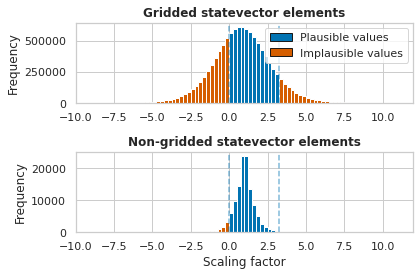

Ratio in range gridded: 0.5616735591662712
Ratio in range non-gridded: 0.9320593403622601


In [8]:
from matplotlib.patches import Rectangle

print(weekly_sv.sf.values)
fig = plt.figure()
fig.set_size_inches(6, 4)
ax = fig.add_subplot(2, 1, 1)
data = weekly_sv.sel(regions = list_gridded_elems).sf.values.flatten()
gridded_ratio_in_range = count(data, 0, 3)/len(data) 
hist = ax.hist(data, bins=80, range=[-9, 11])

for i in range(len(hist[0])):
    if (hist[1][i] < 0) or (hist[1][i] > 3):
        hist[2][i].set_facecolor('C3')
        #hist[2][i].set_alpha(0.5)
    #else:
        #hist[2][i].set_facecolor('C0')
        #hist[2][i].set_alpha(0.5)
# L = ax.legend(*hist.legend_elements(),
#                     loc="upper left", title="TC_region")
# #ax.set_xscale('log')
handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in ['C0','C3']]
labels= ["Plausible values","Implausible values"]
plt.axvline(x=0.0, color='b', alpha=0.5, linestyle='--', label='Deliminer of plausible values')
plt.axvline(x=3.25, color='b', alpha=0.5, linestyle='--')
handles, labels = ax.get_legend_handles_labels() # Some some reason, old handles can no longer be included. Needs additional debuging
new_handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in ['C0','C3']]
new_labels = ["Plausible values","Implausible values"]
new_handles.append(handles)
new_labels.append(labels)
print(handles)
plt.legend(new_handles, new_labels)
# plt.xlabel('Scaling factor')
plt.ylabel('Frequency')
plt.title('Gridded statevector elements',fontweight="bold")
plt.tight_layout()

ax = fig.add_subplot(2, 1, 2)


data = weekly_sv.sel(regions = list_non_gridded_elems).sf.values.flatten()
non_gridded_ratio_in_range = count(data, 0, 3)/len(data) 

hist = ax.hist(data, bins=80, range=[-9, 11])

for i in range(len(hist[0])):
    if (hist[1][i] < 0) or (hist[1][i] > 3):
        hist[2][i].set_facecolor('C3')
        #hist[2][i].set_alpha(0.5)
    #else:
        #hist[2][i].set_facecolor('C0')
        #hist[2][i].set_alpha(0.5)
# L = ax.legend(*hist.legend_elements(),
#                     loc="upper left", title="TC_region")
# #ax.set_xscale('log')
handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in ['C0','C3']]
labels= ["Plausible values","Implausible values"]
plt.axvline(x=0.0, color='b', alpha=0.5, linestyle='--', label='Deliminer of plausible values')
plt.axvline(x=3.25, color='b', alpha=0.5, linestyle='--')

plt.xlabel('Scaling factor')
plt.ylabel('Frequency')
plt.title('Non-gridded statevector elements',fontweight="bold")
plt.tight_layout()

plt.savefig('../figures/Hist_sf_gid_vs_non-grid.pdf')

plt.show()

print(f'Ratio in range gridded: {gridded_ratio_in_range}')
print(f'Ratio in range non-gridded: {non_gridded_ratio_in_range}')

In [83]:
print(np.min(np.unique(weekly_sf_eco.values.flatten())))
print(np.max(np.unique(weekly_sf_eco.values.flatten())))

-19.383621
21.229156


[[ 0.22090822  0.7193689   0.66757655 ...  0.8406952   0.5112342
   0.24654281]
 [-0.41589096  2.77024    -1.2338269  ...  0.8296974  -0.24451458
   0.06314436]
 [-2.15759    -2.9892406   1.1339113  ...  2.9272676   1.5087008
   2.3404195 ]
 ...
 [ 0.5680339   0.6887325   1.1633148  ...  1.1235013   1.1602018
   0.8562129 ]
 [ 0.8449193   0.7945672   1.3593285  ...  0.51651484 -0.4357439
   0.76062596]
 [ 2.3855116   1.4498196   0.65083843 ...  0.27326834  0.8827452
   0.91761464]]


/scratch-local/awoude/ipykernel_1231115/1646738021.py:34: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x14d4994597f0>] instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend(new_handles, new_labels)


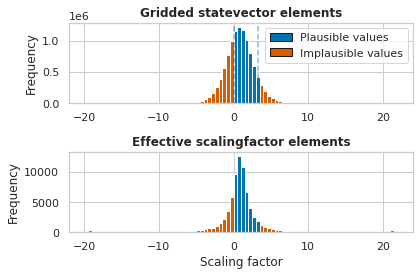

Ratio in range gridded: 0.5616735591662712
Ratio in range effective_sf: 0.6240070845856591


In [47]:
file = pred_var_path+'vars_per_eco_update.nc'

with xr.open_dataset(file) as ds:
    weekly_sf_eco = ds.sf_per_eco
    
print(weekly_sf_eco.values)
fig = plt.figure()
fig.set_size_inches(6, 4)

ax = fig.add_subplot(2, 1, 1)
data = weekly_sv.sel(regions = list_gridded_elems)
hist = ax.hist(data.sf.values.flatten(), bins=84, range=[-20, 22])

for i in range(len(hist[0])):
    if (hist[1][i] < 0) or (hist[1][i] > 3):
        hist[2][i].set_facecolor('C3')
        #hist[2][i].set_alpha(0.5)
    #else:
        #hist[2][i].set_facecolor('C0')
        #hist[2][i].set_alpha(0.5)
# L = ax.legend(*hist.legend_elements(),
#                     loc="upper left", title="TC_region")
# #ax.set_xscale('log')
handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in ['C0','C3']]
labels= ["Plausible values","Implausible values"]
plt.axvline(x=0.0, color='b', alpha=0.5, linestyle='--', label='Deliminer of plausible values')
plt.axvline(x=3.25, color='b', alpha=0.5, linestyle='--')
handles, labels = ax.get_legend_handles_labels() # Some some reason, old handles can no longer be included. Needs additional debuging
new_handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in ['C0','C3']]
new_labels = ["Plausible values","Implausible values"]
new_handles.append(handles)
new_labels.append(labels)
print(handles)
plt.legend(new_handles, new_labels)
# plt.xlabel('Scaling factor')
plt.ylabel('Frequency')
plt.title('Gridded statevector elements',fontweight="bold")
plt.tight_layout()

ax = fig.add_subplot(2, 1, 2)

data = weekly_sf_eco.values.flatten()
eff_sf_ratio_in_range = count(data, 0, 3)/len(data) 
hist = ax.hist(data, bins=84, range=[-20, 22])

for i in range(len(hist[0])):
    if (hist[1][i] < 0) or (hist[1][i] > 3):
        hist[2][i].set_facecolor('C3')
        #hist[2][i].set_alpha(0.5)
    #else:
        #hist[2][i].set_facecolor('C0')
        #hist[2][i].set_alpha(0.5)
# L = ax.legend(*hist.legend_elements(),
#                     loc="upper left", title="TC_region")
# #ax.set_xscale('log')

plt.xlabel('Scaling factor')
plt.ylabel('Frequency')
plt.title('Effective scalingfactor elements',fontweight="bold")
plt.tight_layout()
plt.savefig('../figures/Hist_grid_vs_eff.pdf')
plt.show()


print(f'Ratio in range gridded: {gridded_ratio_in_range}')
print(f'Ratio in range effective_sf: {eff_sf_ratio_in_range}')

In [10]:
weekly_sv.rename({'regions':"eco_regions"}).sf

<xarray.DataArray 'sf' (time: 1096, eco_regions: 9798)>
array([[-1.138994, -0.407153,  3.089636, ...,  1.132833,  0.038254,  1.      ],
       [ 0.726102,  1.029   ,  0.812991, ...,  1.172543, -0.252568,  1.      ],
       [-0.539642,  0.466499,  0.125779, ..., -1.000857,  3.625042,  1.      ],
       ...,
       [ 1.666229,  1.875805,  2.075839, ...,  1.956967, -0.003967,  1.      ],
       [ 0.26539 , -0.042033,  0.383702, ...,  1.115407,  1.071122,  1.      ],
       [ 2.397228,  1.521446,  1.06871 , ...,  1.848454,  0.172243,  1.      ]])
Coordinates:
  * eco_regions  (eco_regions) float64 1.0 2.0 3.0 ... 9.834e+03 9.835e+03
  * time         (time) datetime64[ns] 2000-01-01 2000-01-08 ... 2020-12-26
Attributes:
    Description:  Weekly analysed state vector
    Units:        None

In [59]:
gridded_sv_elems.keys()

dict_keys([1.0, 2.0, 7.0, 8.0, 11.0])

0
ratio of realistic effective scaling factors of region North American Boreal: 0.5867825482867263
1
ratio of realistic effective scaling factors of region North American Temperate: 0.5104426799694309
6
ratio of realistic effective scaling factors of region Eurasia Boreal: 0.5527342559984402
7
ratio of realistic effective scaling factors of region Eurasia Temperate: 0.5982689549365094
10
ratio of realistic effective scaling factors of region Europe: 0.5241031338506528


/scratch-local/awoude/ipykernel_1231115/1114627076.py:69: UserWarning: Legend does not support [] instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend(new_handles, new_labels)


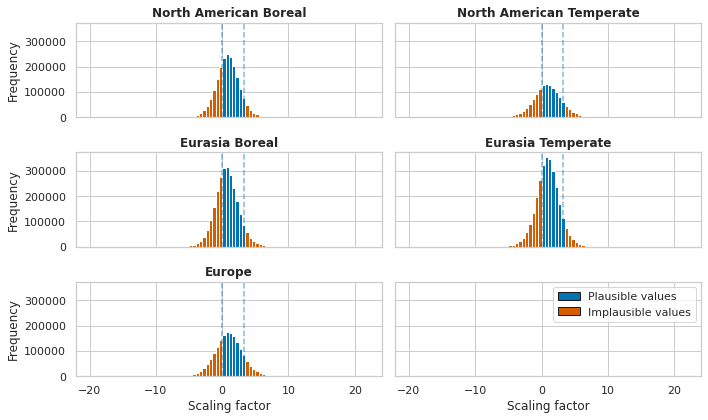

In [11]:
from matplotlib.patches import Rectangle

use_eff_sf = False

continent_dict = {0:'North American Boreal',
                   1:'North American Temperate',
                   2:'South American Tropical', 
                   3:'South American Temperate',
                   4:'Northern Africa',
                   5:'Southern Africa',
                   6:'Eurasia Boreal',
                   7:'Eurasia Temperate',
                   8:'Tropical Asia',
                   9:'Australia',
                   10:'Europe',
                   11:'Seven seas (open ocean)',
                   12:'Not optimized',
                   13:'Out of bounds'
                  }

file = pred_var_path+'vars_per_eco_update.nc'

with xr.open_dataset(file) as ds:
    weekly_sf_eco = ds.sf_per_eco
#     weekly_sf_eco = weekly_sv.rename({'regions':"eco_regions"}).sf
transcom_region = ((weekly_sf_eco.eco_regions-1)/19).astype(int)
transcom_region = transcom_region.rename('transcom_region')

comb_ds = xr.merge([transcom_region, weekly_sf_eco])

grouped = comb_ds.groupby('transcom_region')
fig, axes = plt.subplots(3,2, sharex=True, sharey=True)

for i, group in enumerate(grouped.groups.keys()):
    print(group)
    x_loc = i%2
    y_loc = int(i/2)
    ax = axes[y_loc][x_loc]
    if use_eff_sf:
        data = grouped[group].sf_per_eco.values.flatten()
    else:
        data = weekly_sv.sel(regions=gridded_sv_elems[int(group)+1]).sf.values.flatten()
    hist = ax.hist(data, bins=84, range=[-20, 22])
    ax.set_title(continent_dict[group], fontweight="bold")
    eff_sf_ratio_in_range = count(data, 0, 3)/len(data)
    print(f"ratio of realistic effective scaling factors of region {continent_dict[group]}: {eff_sf_ratio_in_range}")
    for i in range(len(hist[0])):
        if (hist[1][i] < 0) or (hist[1][i] > 3):
            hist[2][i].set_facecolor('C3')

    
    ax.axvline(x=0.0, color='b', alpha=0.5, linestyle='--', label='Deliminer of plausible values')
    ax.axvline(x=3.25, color='b', alpha=0.5, linestyle='--')
    
for yax in axes:    
    yax[0].set_ylabel('Frequency')
for ax in axes[2][:]:
    ax.set_xlabel('Scaling factor')


handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in ['C0','C3']]
labels= ["Plausible values","Implausible values"]    
handles, labels = ax.get_legend_handles_labels() # Some some reason, old handles can no longer be included. Needs additional debuging
new_handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in ['C0','C3']]
new_labels = ["Plausible values","Implausible values"]
new_handles.append(handles)
new_labels.append(labels)
# print(handles)
plt.legend(new_handles, new_labels)
plt.tight_layout()
if use_eff_sf:
    plt.savefig('../figures/Hist_eff_sf_eco.pdf')
else:
    plt.savefig('../figures/Hist_sf_eco.pdf')
plt.show()

0
ratio of realistic raw scaling factors of region North American Boreal: 0.5867825482867263
ratio of realistic effective scaling factors of region North American Boreal: 0.6607498341074983
1
ratio of realistic raw scaling factors of region North American Temperate: 0.5104426799694309
ratio of realistic effective scaling factors of region North American Temperate: 0.5451642335766423
6
ratio of realistic raw scaling factors of region Eurasia Boreal: 0.5527342559984402
ratio of realistic effective scaling factors of region Eurasia Boreal: 0.6164841849148418
7
ratio of realistic raw scaling factors of region Eurasia Temperate: 0.5982689549365094
ratio of realistic effective scaling factors of region Eurasia Temperate: 0.5645855057351408
10
ratio of realistic raw scaling factors of region Europe: 0.5241031338506528
ratio of realistic effective scaling factors of region Europe: 0.742639902676399


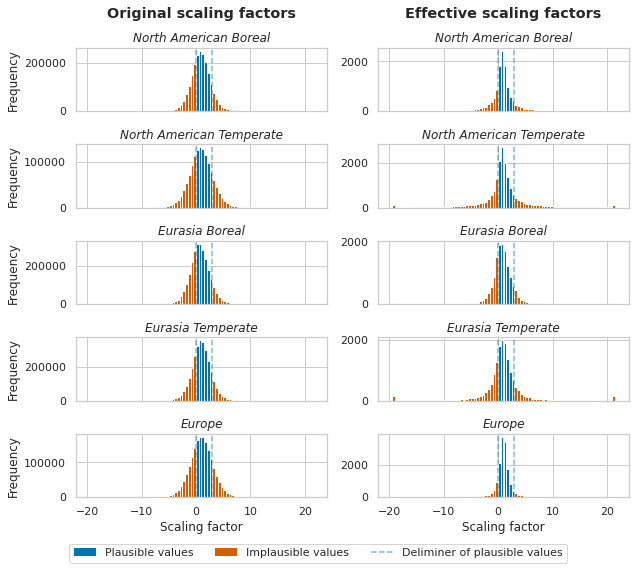

In [56]:
from matplotlib.patches import Rectangle

continent_dict = {0:'North American Boreal',
                   1:'North American Temperate',
                   2:'South American Tropical', 
                   3:'South American Temperate',
                   4:'Northern Africa',
                   5:'Southern Africa',
                   6:'Eurasia Boreal',
                   7:'Eurasia Temperate',
                   8:'Tropical Asia',
                   9:'Australia',
                   10:'Europe',
                   11:'Seven seas (open ocean)',
                   12:'Not optimized',
                   13:'Out of bounds'
                  }

file = pred_var_path+'vars_per_eco_update.nc'

with xr.open_dataset(file) as ds:
    weekly_sf_eco = ds.sf_per_eco
#     weekly_sf_eco = weekly_sv.rename({'regions':"eco_regions"}).sf
transcom_region = ((weekly_sf_eco.eco_regions-1)/19).astype(int)
transcom_region = transcom_region.rename('transcom_region')

comb_ds = xr.merge([transcom_region, weekly_sf_eco])

grouped = comb_ds.groupby('transcom_region')
fig, axes = plt.subplots(5,2, sharex=True, figsize=(9,8))

for i, group in enumerate(grouped.groups.keys()):
    print(group)
    ax_raw = axes[i][0]
    ax_eff = axes[i][1]
#     if use_eff_sf:
    data_eff_sf = grouped[group].sf_per_eco.values.flatten()
#     else:
    data_raw_sv = weekly_sv.sel(regions=gridded_sv_elems[int(group)+1]).sf.values.flatten()
    for data, ax, aggr_meth in zip([data_raw_sv, data_eff_sf], [ax_raw, ax_eff], ['raw', 'effective']):
        hist = ax.hist(data, bins=84, range=[-20, 22])
        ax.set_title(continent_dict[group], style='italic')
        eff_sf_ratio_in_range = count(data, 0, 3)/len(data)
        print(f"ratio of realistic {aggr_meth} scaling factors of region {continent_dict[group]}: {eff_sf_ratio_in_range}")
        for i in range(len(hist[0])):
            if (hist[1][i] < 0) or (hist[1][i] >= 3):
                hist[2][i].set_facecolor('C3')


        ax.axvline(x=0.0, color='b', alpha=0.5, linestyle='--', label='Deliminer of plausible values')
        ax.axvline(x=3.0, color='b', alpha=0.5, linestyle='--')
    
for yax in axes:    
    yax[0].set_ylabel('Frequency')
for xax in axes[4][:]:
    xax.set_xlabel('Scaling factor')
    
pad = 30 # in points

for ax, col_name in zip(axes[0], ['Original scaling factors', 'Effective scaling factors']):
    ax.annotate(col_name, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline', fontweight="bold")


# handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in ['C0','C3']]
# labels= ["Plausible values","Implausible values"]    
handles, labels = ax.get_legend_handles_labels() # Some some reason, old handles can no longer be included. Needs additional debuging
new_handles = [Rectangle((0,0),1,1,linewidth=0,color=c,ec="k") for c in ['C0','C3']]
new_labels = ["Plausible values","Implausible values"]
new_handles = np.concatenate([new_handles, handles])
new_labels = np.concatenate([new_labels, labels])

plt.tight_layout()
fig.subplots_adjust(bottom=0.12, top=0.9)   ##  Need to play with this number to make column names and legend fit.

fig.legend(new_handles, new_labels, loc="lower center", ncol=3)

plt.savefig('../figures/Hist_grid_vs_eff_eco.pdf')
plt.show()

In [30]:
new_handles

In [18]:
print(hist)

(array([2.31000e+02, 2.79000e+02, 3.46000e+02, 4.46000e+02, 4.79000e+02,
       6.13000e+02, 6.93000e+02, 8.15000e+02, 1.00600e+03, 1.24400e+03,
       1.43000e+03, 1.88900e+03, 2.23300e+03, 2.69800e+03, 3.27500e+03,
       4.03800e+03, 5.01100e+03, 6.08400e+03, 7.47100e+03, 9.30100e+03,
       1.16950e+04, 1.44640e+04, 1.78910e+04, 2.26730e+04, 2.83020e+04,
       3.57490e+04, 4.55640e+04, 5.71540e+04, 7.17980e+04, 8.98130e+04,
       1.12220e+05, 1.40186e+05, 1.73194e+05, 2.11720e+05, 2.56141e+05,
       3.06396e+05, 3.60204e+05, 4.15031e+05, 4.70242e+05, 5.23689e+05,
       5.70504e+05, 6.04224e+05, 6.25494e+05, 6.37422e+05, 6.21735e+05,
       5.84430e+05, 5.35944e+05, 4.86329e+05, 4.31897e+05, 3.77068e+05,
       3.24762e+05, 2.75625e+05, 2.30568e+05, 1.91337e+05, 1.57362e+05,
       1.27957e+05, 1.03448e+05, 8.47890e+04, 6.75250e+04, 5.47820e+04,
       4.37830e+04, 3.55120e+04, 2.84650e+04, 2.27280e+04, 1.84910e+04,
       1.49460e+04, 1.19290e+04, 9.65100e+03, 7.88700e+03, 6.36

In [26]:
import time
# Combine all scaling factors together in a dataframe
now = time.time()
file_name = 'weekly_sv.nc'
file_path = pers_file_dir + file_name
with xr.open_dataset(state_vec_file) as ds:
    state_vec_params = ds
    # fixing minor error in the naming of dimensions in the source file:
    ds = ds.swap_dims({"longitude": "lon2", "latitude":"lat2", "lon":"lon2", "lat":"lat2"})
    ds = ds.swap_dims({"lon2": "lon", "lat2":"lat"})
    ds = ds.reset_coords(names=['longitude' ,'latitude'], drop=True)
    
    state_elem_ds = ds
ds = xr.Dataset(None)
sv = {}
for i, f in enumerate(sf_files[:5]):
    with xr.open_dataset(f) as ds:
        print(f"Currently processing file #{i}")
        date = extract_date(f)
        sf_per_er = get_state_vec(f, state_elem_ds)
        sv[date] = sf_per_er

sv_dat_arr = xr.concat(list(sv.values()), pd.Index(list(sv.keys()), name="time"))
sv_dat_arr.attrs['Description'] = 'Weekly analysed state vector'
sv_dat_arr.attrs['Units'] = 'None'
# sv_dat_arr.to_netcdf(file_path)
# os.chmod(file_path, stat.S_IRWXU) # Needed for setting permissions after writing
print(f'total time: {time.time()-now}')

Currently processing file #0
<xarray.Dataset>
Dimensions:            (lat: 180, lon: 360)
Coordinates:
  * lat                (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lon                (lon) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
Data variables:
    regions            (lat, lon) float32 ...
    land_ecosystems    (lat, lon) float32 ...
    transcom_regions   (lat, lon) float32 ...
    ocean_regions      (lat, lon) float32 ...
    flux_multiplier_m  (lat, lon) float32 ...
Attributes: (12/15)
    Institution:  Wageningen University and Research Center
    Contact:      wouter.peters@wur.nl
    URL:          http://carbontracker.wur.nl
    Convention:   CF-1.1
    Disclaimer:   This data belongs to the CarbonTracker project
    Source:       CarbonTracker release CT2010
    ...           ...
    email:        carbontracker.team@noaa.gov
    url:          http://carbontracker.noaa.gov
    institution:  NOAA Earth System Research Laboratory
    Conventions: 

# Figure 4.2
Analyzing the forward runs. Unfortunately, all the remaining plots require observation data which cannot be shared according to the use policy. The exact conditions under which it can be shared remain vague, and it is better to put make them public. However, the required file, `run_evaluation.pkl`, could be shared upon request. Please contact h.m.roothaert@gmail.com if interested.

In [30]:
save_file = SAVE_DIR + 'run_evaluation.pkl'


df = pd.read_pickle(save_file)

In [31]:
# Filter out the stations where not every run has the same amount of measurements

invalid_stations = []
for station in np.unique(df.index):
    if len(np.unique(df.loc[station].N))>1: # This would mean a station does not have the same number of observations per run
        print(df.loc[station])
        invalid_stations.append(station)
print(f'total list of invalid stations: {invalid_stations}')


total list of invalid stations: []


In [32]:
print(df[['run','rmse']])

           run       rmse
ABT      prior  12.665291
ABT   smoothed  13.615030
ABT    monthly   6.027907
ABT  optimized  13.130272
ACT      prior   4.772467
..         ...        ...
YON  optimized   2.291008
ZEP    monthly   1.326189
ZEP   smoothed   2.180865
ZEP  optimized   1.371511
ZEP      prior   4.058110

[588 rows x 2 columns]


/scratch-local/awoude/ipykernel_2896596/3950672946.py:16: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  figs = df.boxplot(ax=ax, by =['order'],


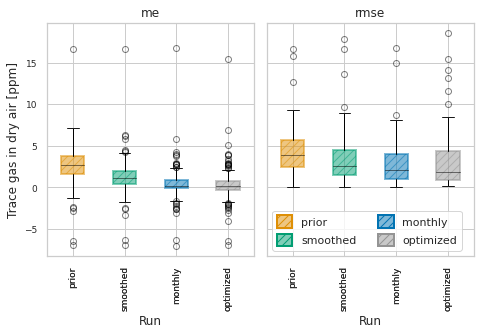

N=147
total number of observations: 
run
monthly      617090
optimized    617090
prior        617090
smoothed     617090
Name: N, dtype: int64
average ME: 
run
monthly      0.412324
optimized    0.342779
prior        2.651622
smoothed     1.272908
Name: me, dtype: float32
average RMSE: 
run
monthly      2.855059
optimized    3.131132
prior        4.274340
smoothed     3.398294
Name: rmse, dtype: float32


In [53]:
save_file = SAVE_DIR + 'run_evaluation.pkl'
df = pd.read_pickle(save_file)
df = df[~df.index.isin(invalid_stations)] # Remove all invalid stations

run_order = {'prior':0,
             'smoothed':1,
             'monthly':2, 
             'optimized':3}
df['order']=df['run'].replace(run_order)

fig, ax = plt.subplots(figsize=(7,5))

figs = df.boxplot(ax=ax, by =['order'], 
                column =['me', 'rmse'],
                grid = True, 
                rot = 90,
                fontsize = 9,
                return_type='both',
                patch_artist=True
                 )

figs[0].ax.set_ylabel('Trace gas in dry air [ppm]')
figs[0].ax.set_xticklabels(list(run_order.keys())*2)


colors = [1, 2, 0, 7]
for bplot in figs:
    for patch, color in zip(bplot.lines['boxes'], colors):
        patch.set_fc(pal[color])
        patch.set_alpha(0.5)
        patch.set_hatch('///')
        patch.set_ec(pal[color])
        patch.set_linewidth(2)
    for patch, color in zip(bplot.lines['fliers'], colors*12):
        patch.set_alpha(0.5) 
    for line in bplot.lines['medians']:
        line.set_color('black')
        line.set_alpha(0.5)
    bplot.ax.set_xlabel('Run')
    
prior_patch = Rectangle((0,0),10,10,
                    edgecolor=pal[colors[0]],
                    facecolor=(*pal[colors[0]], 0.5),
                    lw=2,
                    hatch='///',
#                     alpha=0.5,
                    label = 'prior')
smoothed_patch = Rectangle((0,0),10,10,
                    edgecolor=pal[colors[1]],
                    facecolor=(*pal[colors[1]], 0.5),
                    lw=2,
                    hatch='///',
#                     alpha=0.5,
                    label = 'smoothed')
monthly_patch = Rectangle((0,0),10,10,
                    edgecolor=pal[colors[2]],
                    facecolor=(*pal[colors[2]], 0.5),
                    lw=2,
                    hatch='///',
#                     alpha=0.5,
                    label = 'monthly')
optimized_patch = Rectangle((0,0),10,10,
                    edgecolor=pal[colors[3]],
                    facecolor=(*pal[colors[3]], 0.5),
                    lw=2,
                    hatch='///',
#                     alpha=0.5,
                    label = 'optimized')

plt.legend(handles=[prior_patch, smoothed_patch, monthly_patch, optimized_patch], handlelength=1.4, handleheight=1.4, ncol=2)
figs[0].ax.get_figure().suptitle('')
plt.tight_layout()
#plt.show()

plt.savefig('../figures/forward_partI.pdf')
plt.show()

print(f'N={len(np.unique(df.index))}')
print(f"total number of observations: \n{df[['N', 'run']].groupby(['run']).sum().N}")
print(f"average ME: \n{df[['me', 'run']].groupby(['run']).mean().me}")
print(f"average RMSE: \n{df[['rmse', 'run']].groupby(['run']).mean().rmse}")

In [57]:
np.unique(df.continent)

array(['Australia', 'Eurasia Temperate', 'Europe',
       'North American Boreal', 'North American Temperate',
       'Northern Africa', 'Not optimized', 'Out of bounds',
       'Seven seas (open ocean)', 'South American Temperate',
       'Southern Africa', 'Tropical Asia'], dtype=object)

In [49]:
tc_names

['North American Boreal',
 'North American Temperate',
 'South American Tropical',
 'South American Temperate',
 'Northern Africa',
 'Southern Africa',
 'Eurasia Boreal',
 'Eurasia Temperate',
 'Tropical Asia',
 'Australia',
 'Europe',
 'North Pacific Temperate',
 'West Pacific Tropical',
 'East Pacific Tropical',
 'South Pacific Temperate',
 'Northern Ocean',
 'North Atlantic Temperate',
 'Atlantic Tropical',
 'South Atlantic Temperate',
 'Southern Ocean',
 'Indian Tropical',
 'South Indian Temperate',
 'Not optimized']

[0, 1, 2, 3, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 32, 33, 35, 36, 37, 38, 40, 41, 42, 43, 45, 46, 47, 48, 50, 51, 52, 53, 55, 56, 57, 58]


/scratch-local/awoude/ipykernel_2896596/3176636902.py:36: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  figs = df.boxplot(ax=ax, by =['continent_order', 'run_order'],


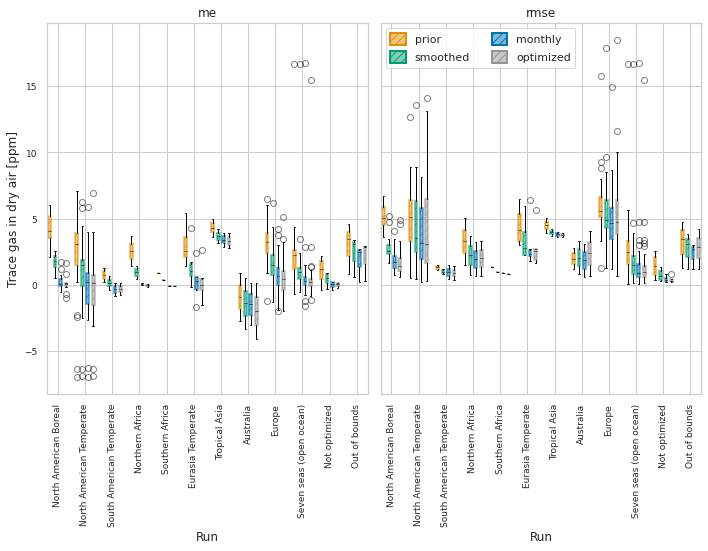

run        continent               
monthly    Australia                    2
           Eurasia Temperate            6
           Europe                      31
           North American Boreal       14
           North American Temperate    35
           Northern Africa              2
           Not optimized                4
           Out of bounds                3
           Seven seas (open ocean)     45
           South American Temperate     2
           Southern Africa              1
           Tropical Asia                2
optimized  Australia                    2
           Eurasia Temperate            6
           Europe                      31
           North American Boreal       14
           North American Temperate    35
           Northern Africa              2
           Not optimized                4
           Out of bounds                3
           Seven seas (open ocean)     45
           South American Temperate     2
           Southern Africa              

In [61]:
save_file = SAVE_DIR + 'run_evaluation.pkl'
df = pd.read_pickle(save_file)
df = df[~df.index.isin(invalid_stations)] # remove all invalid stations

fig, ax = plt.subplots(figsize=(10,8))

run_order = {'prior':0,
             'smoothed':1,
             'monthly':2, 
             'optimized':3}
continent_order = {'North American Boreal':1,
                   'North American Temperate':2,
                   #'South American Tropical':3, # no measurements present within this transcom region
                   'South American Temperate':4,
                   'Northern Africa':5,
                   'Southern Africa':6,
                   #'Eurasia Boreal':7,
                   'Eurasia Temperate':8,
                   'Tropical Asia':9,
                   'Australia':10,
                   'Europe':11,
                   'Seven seas (open ocean)':12,
                   'Not optimized':13,
                   'Out of bounds':14
                  }
df['run_order']=df['run'].replace(run_order)
df['continent_order']=df['continent'].replace(continent_order)


pos = [[(i*5)+j for j in range(4)] for i in range(12)]
pos = sum(pos, [])
print(pos)
figs = df.boxplot(ax=ax, by =['continent_order', 'run_order'], 
                                            column =['me','rmse'],
                                            grid = True, 
                                            rot = 90,
                                            positions = pos,
                                            fontsize = 9,
                                            return_type='both',
                                            patch_artist=True
                                             )
figs[0].ax.set_ylabel('Trace gas in dry air [ppm]')
figs[0].ax.set_xticks(np.arange(1.5, len(continent_order) * 5+1.5, 5))

figs[0].ax.set_xticklabels(list(continent_order.keys()))



colors = [1, 2, 0, 7]
for bplot in figs:
    for patch, color in zip(bplot.lines['boxes'], colors*12):
        patch.set_fc(pal[color])
        patch.set_alpha(0.5)
        patch.set_hatch('///')
        patch.set_ec(pal[color])
        patch.set_linewidth(2)
    for patch, color in zip(bplot.lines['fliers'], colors*12):
        patch.set_alpha(0.5) 
    for line in bplot.lines['medians']:
        line.set_color('black')
        line.set_alpha(0.5)
    bplot.ax.set_xlabel('Run')
    
prior_patch = Rectangle((0,0),10,10,
                    edgecolor=pal[colors[0]],
                    facecolor=(*pal[colors[0]], 0.5),
                    lw=2,
                    hatch='///',
#                     alpha=0.5,
                    label = 'prior')
smoothed_patch = Rectangle((0,0),10,10,
                    edgecolor=pal[colors[1]],
                    facecolor=(*pal[colors[1]], 0.5),
                    lw=2,
                    hatch='///',
#                     alpha=0.5,
                    label = 'smoothed')
monthly_patch = Rectangle((0,0),10,10,
                    edgecolor=pal[colors[2]],
                    facecolor=(*pal[colors[2]], 0.5),
                    lw=2,
                    hatch='///',
#                     alpha=0.5,
                    label = 'monthly')
optimized_patch = Rectangle((0,0),10,10,
                    edgecolor=pal[colors[3]],
                    facecolor=(*pal[colors[3]], 0.5),
                    lw=2,
                    hatch='///',
#                     alpha=0.5,
                    label = 'optimized')
plt.legend(handles=[prior_patch, smoothed_patch, monthly_patch, optimized_patch], handlelength=1.4, handleheight=1.4, ncol=2)

figs[0].ax.get_figure().suptitle('')
plt.tight_layout()
plt.savefig('../figures/forward_partI_transcomregion.pdf')
plt.show()
df_gb = df[['run', 'continent', 'N']].groupby(['run', 'continent'])
print(df_gb.size())
print(df_gb.sum().N)

# Figure 1.2
Creating overview of the used measuring stations.

/scratch-local/awoude/ipykernel_2385789/434141826.py:24: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x,y,label in zip (continents.geometry.centroid.x, continents.geometry.centroid.y, continents.index):
/scratch-local/awoude/ipykernel_2385789/434141826.py:24: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x,y,label in zip (continents.geometry.centroid.x, continents.geometry.centroid.y, continents.index):


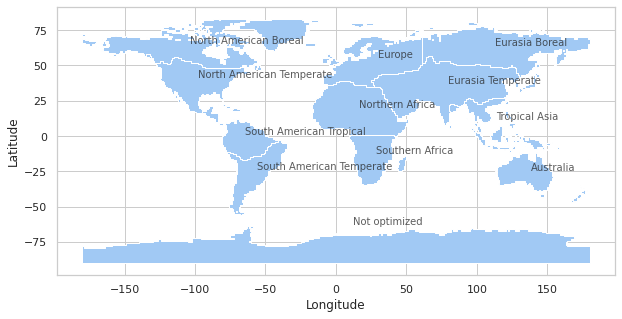

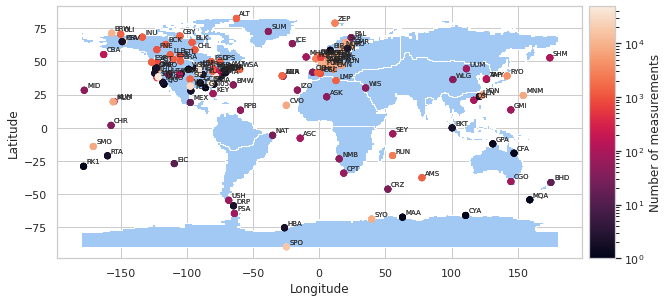

In [13]:
sns.set(style="whitegrid", palette="pastel", color_codes=True)

save_file = SAVE_DIR + 'run_evaluation.pkl'
df = pd.read_pickle(save_file)

df = df.rename(columns ={'location':'geometry'})

shape_earth = Polygon([(-180, 90), (-180, -90), (180, -90), (180, 90)])
df = df.where(gpd.GeoSeries(df.geometry).within(shape_earth))

fig, ax = plt.subplots(figsize=(10,10))

sf = gpd.read_file(continents_file)
land_indeces = list(range(0,11))+ [22]
sf = sf.iloc[land_indeces]
continents = sf[['transcom_n', 'geometry']].dissolve(by='transcom_n', sort=False)

continents.plot(ax=ax)
for x,y,label in zip (continents.geometry.centroid.x, continents.geometry.centroid.y, continents.index):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", alpha=0.75, fontsize=10)

ax.set_ylabel("Latitude")
ax.set_xlabel("Longitude")


plt.savefig('../figures/TransCom_dist.pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(10,10))

sf = gpd.read_file(continents_file)
land_indeces = list(range(0,11))+ [22]
sf = sf.iloc[land_indeces]

continents = sf[['transcom_n', 'geometry']].dissolve(by='transcom_n', sort=False)
continents.plot(ax=ax)

divider = make_axes_locatable(ax)

cax = divider.append_axes("right", size="5%", pad=0.1)


df = gpd.GeoDataFrame(df)
df.plot(ax=ax, column='N', legend=True, 
        norm=mpl.colors.LogNorm(vmin=df.N.min(), vmax=df.N.max()), 
        cax=cax, legend_kwds={'label': "Number of measurements"})

for x, y, label in zip(df.geometry.x, df.geometry.y, df.index):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", alpha=0.5, fontsize=7)

ax.set_ylabel("Latitude")
ax.set_xlabel("Longitude")
plt.savefig('../figures/dist_observations.pdf', bbox_inches='tight')
plt.show()

sns.set(style="whitegrid", palette="colorblind", color_codes=True)


# Supplementory figures

In [3]:
def get_stddev_obs(run, sites=[], files=[]):
    """Get CTE mole fractions"""
    dfs = []
    path = MAIN_DIR + run + '/'
    if len(sites)!=0:
        files = sorted(glob(path + '*.nc'))
        #print(files)
        req_sites = [s.lower() for s in sites]
        #print(req_sites)
        filtered_files = [file for file in files if any(site in file.split('/')[-1] for site in req_sites)]
    elif len(files)!=0:
        filtered_files = [path+f for f in files]
    else:
        raise RuntimeError(f"No sites or files specified for analysing run {run}")
    for f in filtered_files:
        #print(f)
        with nc.Dataset(f) as ds:
            name = ds.site_code
            # if not name in sites: continue
            df = pd.DataFrame()
            
            times = np.array(nc.num2date(ds['time'][:], ds['time'].units))
            times = np.array([dtm.datetime(t.year, t.month, t.day, t.hour) for t in times])
            inds = np.where((times >= dtm.datetime(2000, 1, 1, 0)) & (times < dtm.datetime(2021, 1, 1, 0)))[0]
            

            # height = ds['intake_height'][inds] --> Is this really needed?
            df['time'] = times[inds]
            df['stddev'] = ds['modelsamplesstandarddeviation'][inds]*1e6
            df['name'] = name
            # df = df[(df.time >= dtm.datetime(2019, 1, 5, 0)) & (df.time < dtm.datetime(2020, 12, 31, 0))] # filtering out all measurements that happened before the first saterday of 2019
            #gdf = gpd.GeoDataFrame(df, geometry=Point(ds.site_longitude,ds.site_latitude))

#             df['height'] = height # Kan je toevoegen, hoeft voor nu niet denk ik
            dfs.append(df)
    df = pd.concat(dfs)
    df.index = [df['time'], df['name']]
    df = df.drop(['time', 'name'], axis=1)
    return df

complete_obs_files = set([os.path.basename(x) for x in glob(MAIN_DIR + 'optimized_incorrect_2/' + '*.nc')]) # The addition of '_incorrect_2' refers to a mistake in determining scaling factors. It does however contain the full set of available observations. Therefore, is can be used for gaining insight into the observations
df_GCP = get_stddev_obs('optimized_incorrect_2', files=complete_obs_files)


/home/awoude/.conda/envs/Ritten_3.9.10/lib/python3.9/site-packages/numpy/ma/core.py:1013: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)
/home/awoude/.conda/envs/Ritten_3.9.10/lib/python3.9/site-packages/numpy/ma/core.py:1013: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)
/home/awoude/.conda/envs/Ritten_3.9.10/lib/python3.9/site-packages/numpy/ma/core.py:1013: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)
/home/awoude/.conda/envs/Ritten_3.9.10/lib/python3.9/site-packages/numpy/ma/core.py:1013: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)
/home/awoude/.conda/envs/Ritten_3.9.10/lib/python3.9/site-packages/numpy/ma/core.py:1013: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)
/home/awoude/.conda/envs/Ritten_3.9.10/lib/python3.9/site-packages/numpy/ma/core.py:1013: 

/home/awoude/.conda/envs/Ritten_3.9.10/lib/python3.9/site-packages/numpy/ma/core.py:1013: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)
/home/awoude/.conda/envs/Ritten_3.9.10/lib/python3.9/site-packages/numpy/ma/core.py:1013: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)
/home/awoude/.conda/envs/Ritten_3.9.10/lib/python3.9/site-packages/numpy/ma/core.py:1013: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)
/home/awoude/.conda/envs/Ritten_3.9.10/lib/python3.9/site-packages/numpy/ma/core.py:1013: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)
/home/awoude/.conda/envs/Ritten_3.9.10/lib/python3.9/site-packages/numpy/ma/core.py:1013: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)
/home/awoude/.conda/envs/Ritten_3.9.10/lib/python3.9/site-packages/numpy/ma/core.py:1013: 

/home/awoude/.conda/envs/Ritten_3.9.10/lib/python3.9/site-packages/numpy/ma/core.py:1013: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)
/home/awoude/.conda/envs/Ritten_3.9.10/lib/python3.9/site-packages/numpy/ma/core.py:1013: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)
/home/awoude/.conda/envs/Ritten_3.9.10/lib/python3.9/site-packages/numpy/ma/core.py:1013: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)
/home/awoude/.conda/envs/Ritten_3.9.10/lib/python3.9/site-packages/numpy/ma/core.py:1013: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)
/home/awoude/.conda/envs/Ritten_3.9.10/lib/python3.9/site-packages/numpy/ma/core.py:1013: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)
/home/awoude/.conda/envs/Ritten_3.9.10/lib/python3.9/site-packages/numpy/ma/core.py:1013: 

/home/awoude/.conda/envs/Ritten_3.9.10/lib/python3.9/site-packages/numpy/ma/core.py:1013: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)
/home/awoude/.conda/envs/Ritten_3.9.10/lib/python3.9/site-packages/numpy/ma/core.py:1013: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)
/home/awoude/.conda/envs/Ritten_3.9.10/lib/python3.9/site-packages/numpy/ma/core.py:1013: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)
/home/awoude/.conda/envs/Ritten_3.9.10/lib/python3.9/site-packages/numpy/ma/core.py:1013: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)
/home/awoude/.conda/envs/Ritten_3.9.10/lib/python3.9/site-packages/numpy/ma/core.py:1013: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)
/home/awoude/.conda/envs/Ritten_3.9.10/lib/python3.9/site-packages/numpy/ma/core.py:1013: 

/home/awoude/.conda/envs/Ritten_3.9.10/lib/python3.9/site-packages/numpy/ma/core.py:1013: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)
/home/awoude/.conda/envs/Ritten_3.9.10/lib/python3.9/site-packages/numpy/ma/core.py:1013: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)
/home/awoude/.conda/envs/Ritten_3.9.10/lib/python3.9/site-packages/numpy/ma/core.py:1013: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)
/home/awoude/.conda/envs/Ritten_3.9.10/lib/python3.9/site-packages/numpy/ma/core.py:1013: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)
/home/awoude/.conda/envs/Ritten_3.9.10/lib/python3.9/site-packages/numpy/ma/core.py:1013: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)
/home/awoude/.conda/envs/Ritten_3.9.10/lib/python3.9/site-packages/numpy/ma/core.py:1013: 

/home/awoude/.conda/envs/Ritten_3.9.10/lib/python3.9/site-packages/numpy/ma/core.py:1013: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)
/home/awoude/.conda/envs/Ritten_3.9.10/lib/python3.9/site-packages/numpy/ma/core.py:1013: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)
/home/awoude/.conda/envs/Ritten_3.9.10/lib/python3.9/site-packages/numpy/ma/core.py:1013: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)
/home/awoude/.conda/envs/Ritten_3.9.10/lib/python3.9/site-packages/numpy/ma/core.py:1013: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)
/home/awoude/.conda/envs/Ritten_3.9.10/lib/python3.9/site-packages/numpy/ma/core.py:1013: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)
/home/awoude/.conda/envs/Ritten_3.9.10/lib/python3.9/site-packages/numpy/ma/core.py:1013: 

/home/awoude/.conda/envs/Ritten_3.9.10/lib/python3.9/site-packages/numpy/ma/core.py:1013: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)
/home/awoude/.conda/envs/Ritten_3.9.10/lib/python3.9/site-packages/numpy/ma/core.py:1013: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)
/home/awoude/.conda/envs/Ritten_3.9.10/lib/python3.9/site-packages/numpy/ma/core.py:1013: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)
/home/awoude/.conda/envs/Ritten_3.9.10/lib/python3.9/site-packages/numpy/ma/core.py:1013: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)
/home/awoude/.conda/envs/Ritten_3.9.10/lib/python3.9/site-packages/numpy/ma/core.py:1013: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)
/home/awoude/.conda/envs/Ritten_3.9.10/lib/python3.9/site-packages/numpy/ma/core.py:1013: 

/home/awoude/.conda/envs/Ritten_3.9.10/lib/python3.9/site-packages/numpy/ma/core.py:1013: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)
/home/awoude/.conda/envs/Ritten_3.9.10/lib/python3.9/site-packages/numpy/ma/core.py:1013: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)
/home/awoude/.conda/envs/Ritten_3.9.10/lib/python3.9/site-packages/numpy/ma/core.py:1013: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)
/home/awoude/.conda/envs/Ritten_3.9.10/lib/python3.9/site-packages/numpy/ma/core.py:1013: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)
/home/awoude/.conda/envs/Ritten_3.9.10/lib/python3.9/site-packages/numpy/ma/core.py:1013: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)
/home/awoude/.conda/envs/Ritten_3.9.10/lib/python3.9/site-packages/numpy/ma/core.py:1013: 

/home/awoude/.conda/envs/Ritten_3.9.10/lib/python3.9/site-packages/numpy/ma/core.py:1013: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)
/home/awoude/.conda/envs/Ritten_3.9.10/lib/python3.9/site-packages/numpy/ma/core.py:1013: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)
/home/awoude/.conda/envs/Ritten_3.9.10/lib/python3.9/site-packages/numpy/ma/core.py:1013: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)
/home/awoude/.conda/envs/Ritten_3.9.10/lib/python3.9/site-packages/numpy/ma/core.py:1013: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)
/home/awoude/.conda/envs/Ritten_3.9.10/lib/python3.9/site-packages/numpy/ma/core.py:1013: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)
/home/awoude/.conda/envs/Ritten_3.9.10/lib/python3.9/site-packages/numpy/ma/core.py:1013: 

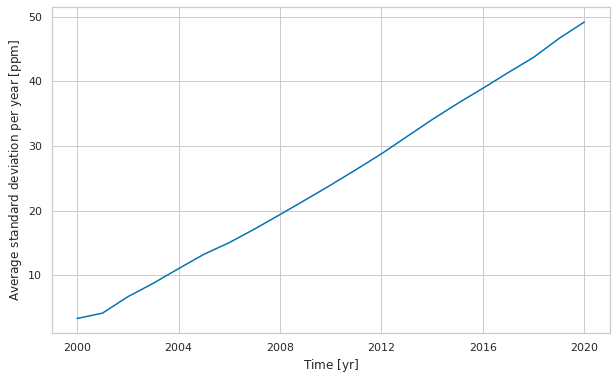

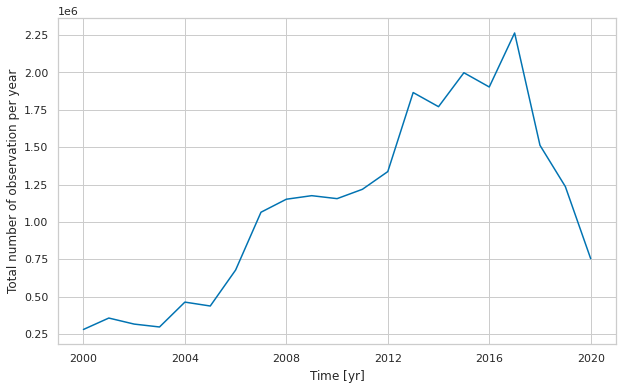

In [4]:
df_GCP.groupby(df_GCP.index.get_level_values('time').year).stddev.mean().plot()
plt.ylabel(r'Average standard deviation per year [$\mathrm{ppm}$]')
plt.xlabel(r'Time [$\mathrm{yr}$]')
plt.xticks(range(2000,2021, 4))
plt.savefig('../figures/stddev_obs_per_year.pdf', bbox_inches='tight')
plt.show()
df_GCP.groupby(df_GCP.index.get_level_values('time').year).size().plot()
plt.ylabel(r'Total number of observation per year')
plt.xlabel(r'Time [$\mathrm{yr}$]')
plt.xticks(range(2000,2021, 4))
plt.savefig('../figures/obs_per_year.pdf', bbox_inches='tight')
plt.show()